# Load Model

In [109]:
import os
from tensorflow.keras.models import load_model
import numpy as np

save_dir = os.path.join("models", "save_experiments")
loaded_model = load_model(os.path.join(save_dir, "saved_model.h5"))

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frame_input (InputLayer)    [(None, 45, 1024)]           0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 45, 10)               51210     ['frame_input[0][0]']         
                                                                                                  
 batch_normalization_3 (Bat  (None, 45, 10)               40        ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)   (None, 45, 10)               0         ['batch_normalization_3[

# Extract Feature from Video

In [119]:
import cv2
from feature_extractor import feature_extractor
# Reference: https://github.com/google/youtube-8m/tree/master/feature_extractor
# Note that the original module only works for TF 1.x but not 2.0,
# we need to modify the script specifically for tf.GraphDef, tf.Graph, and tf.Session to be
# tf.compat.v1.GraphDef tf.compat.v1.Graph and tf.compat.v1.Session, respectively.

CAP_PROP_POS_MSEC = 0

def frame_iterator(filename, every_ms=1000, max_num_frames=300):
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print >> sys.stderr, "Error: Cannot open video file " + filename
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0
    while num_retrieved < max_num_frames:
        # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return
        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1

# Pre-trained ImageNet Inception model and PCA matrices will be downloaded if not found.
extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")

In [120]:
video_file = "./Music2.mp4"  # A test sample.

rgb_features = []
sum_rgb_features = None

fiter = frame_iterator(video_file, every_ms=1000.0)

# Take just one frame.
next(fiter)

rgb = next(fiter)

features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])

In [121]:
max_frames = 45  # Number of frames to extract

for _ in range(max_frames):
    frame = next(fiter, None)
    if frame is None:
        break
    features = extractor.extract_rgb_frame_features(frame[:, :, ::-1])
    rgb_features.append(features)

In [123]:
len(rgb_features) #(45,1024)
rgb_features

[array([ 1.062107  ,  0.6879981 ,  0.5779674 , ..., -0.3031495 ,
        -0.98479825,  0.734415  ], dtype=float32),
 array([ 1.1415992 ,  0.60245645, -0.20983385, ...,  0.99336916,
        -0.08102314,  0.42119175], dtype=float32),
 array([-1.6089453 ,  0.9434264 ,  0.39062893, ..., -0.13625477,
        -0.33111238,  0.7375353 ], dtype=float32),
 array([-0.29719418,  0.673259  ,  1.1579058 , ..., -1.5443954 ,
         1.352723  , -2.2443871 ], dtype=float32),
 array([ 0.6289253 ,  0.7933707 ,  1.5311644 , ...,  0.32662943,
        -0.11816177, -0.4252754 ], dtype=float32),
 array([ 0.5153674 ,  0.540873  ,  1.5407882 , ..., -0.09657417,
        -0.6915221 ,  1.3345691 ], dtype=float32),
 array([ 0.51301503, -0.02494243,  1.4425969 , ..., -0.7988385 ,
        -0.47633457, -2.2793338 ], dtype=float32),
 array([ 0.2137482 , -0.20455712,  2.2018435 , ..., -0.84861594,
         0.77897906, -2.2875748 ], dtype=float32),
 array([ 0.4195894 , -0.25454164,  1.7196542 , ..., -1.7411088 ,
       

In [124]:
# Convert the list to a numpy array
rgb_features_array = np.array(rgb_features)

# Reshape the array to add a new axis at the beginning
rgb_features_array = np.expand_dims(rgb_features_array, axis=0)

In [125]:
# Reshape the features into sequences of 45 frames each
predictions = loaded_model.predict(rgb_features_array)
print(predictions)

1/1 [==============================] - 1s 749ms/step
[[9.9996847e-01 1.3867590e-22 9.8043664e-14 8.9124106e-26 2.2891147e-26
  6.8813052e-26 2.6810454e-21 3.0705624e-22 2.1498939e-02]]


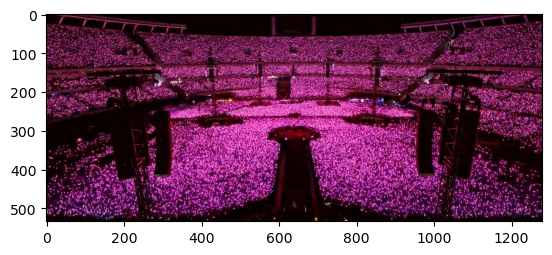

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the extracted frame.
f = plt.imshow(rgb)

In [127]:
# The embeddings generated by the pre-trained Inception model on the above frame.
print(features.shape)
print(features)

(1024,)
[ 0.32068577 -0.00784719  1.0262779  ... -2.2360086   0.52385086
 -1.7608215 ]


In [40]:
import cv2
import numpy as np
from feature_extractor import feature_extractor  # Assuming feature_extractor is your feature extraction module

def extract_video_features(video_file, num_frames=45):
    # Initialize the feature extractor
    extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")
    
    # Initialize a list to store the features
    video_features = []
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)
    
    # Calculate frame skip interval to evenly sample frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(total_frames // num_frames, 1)
    
    # Iterate through the frames of the video
    for i in range(num_frames):
        # Set frame position to skip frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        
        # Read the next frame
        ret, frame = cap.read()
        
        # Check if the frame was successfully read
        if not ret:
            break  # Break the loop if no more frames are available
        
        # Extract features from the frame
        features = extractor.extract_rgb_frame_features(frame[:, :, ::-1])  # Convert BGR to RGB
        
        # Append the features to the list
        video_features.append(features)
    
    # Close the video file
    cap.release()
    
    # Convert the list of features to a numpy array
    video_features = np.array(video_features)
    
    return video_features

# Example usage:
video_file = "./Music2.mp4"
video_features = extract_video_features(video_file, num_frames=45)
print(video_features.shape)  # Check the shape of the extracted features

(45, 1024)


In [88]:
len(video_features[1])

1024

In [42]:
num_frames = video_features.shape[0]
num_sequences = num_frames // 45

import numpy as np

# Reshape the features into sequences of 45 frames each
video_features_reshaped = video_features[:num_sequences * 45].reshape(-1, 45, 1024)

print(video_features_reshaped.shape)  # Check the shape of the reshaped features

predictions = loaded_model.predict(video_features_reshaped)
print(predictions)

(1, 45, 1024)
1/1 [==============================] - 0s 31ms/step
[[9.9996841e-01 1.3548777e-22 9.4511658e-14 8.6673177e-26 2.2238463e-26
  6.5716002e-26 2.6057550e-21 2.9928954e-22 2.1901466e-02]]


In [43]:
predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels)

[0]
